# 手写数字识别 (传统神经网络)

## 导入必要的模块

In [1]:
import numpy as np
import torch

from torchvision.datasets import mnist
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

## 定义超参数

In [2]:
train_batch_size = 64   #每批处理的训练集数据
test_batch_size = 128   #每批处理的测试集数据
learning_rate = 0.01
num_epoches = 20        # 训练数据集的轮次
lr = 0.01
momentum = 0.5

## 加载及预处理数据

In [3]:
# 构建 transform, 对图像做处理
transform = transforms.Compose([
    transforms.ToTensor(), # 将图片转换为tensor
    transforms.Normalize([0.5], [0.5]) # 正则化，降低模型复杂度
])

#下载数据，并对数据进行预处理
#训练集
train_dataset = mnist.MNIST('data', train=True, transform=transform, download=True)
#测试集
test_dataset = mnist.MNIST('data', train=False, transform=transform, download=True)
#加载数据
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



E:\Software\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [5]:
print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


## 可视化源数据

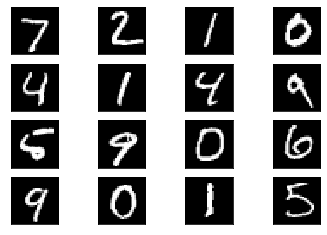

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# 抽取 16 张手写数字图片
fig = plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## 构建模型

In [16]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, out_dim))
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

## 定义损失函数

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net(28 * 28, 300, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # 优化器，用于更新参数

## 训练模型

In [21]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

In [24]:
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.9
        
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1) # 拉平
        # 正向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模式改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1) 
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc 
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch,train_loss / len(train_loader),train_acc / len(train_loader),
                  eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.6360, Train Acc: 0.8907, Test Loss: 1.6020, Test Acc: 0.9115
epoch: 1, Train Loss: 1.6019, Train Acc: 0.9022, Test Loss: 1.5796, Test Acc: 0.9194
epoch: 2, Train Loss: 1.5840, Train Acc: 0.9109, Test Loss: 1.5670, Test Acc: 0.9237
epoch: 3, Train Loss: 1.5726, Train Acc: 0.9165, Test Loss: 1.5585, Test Acc: 0.9284
epoch: 4, Train Loss: 1.5646, Train Acc: 0.9213, Test Loss: 1.5526, Test Acc: 0.9322
epoch: 5, Train Loss: 1.5584, Train Acc: 0.9247, Test Loss: 1.5468, Test Acc: 0.9342
epoch: 6, Train Loss: 1.5535, Train Acc: 0.9277, Test Loss: 1.5435, Test Acc: 0.9369
epoch: 7, Train Loss: 1.5496, Train Acc: 0.9309, Test Loss: 1.5400, Test Acc: 0.9386
epoch: 8, Train Loss: 1.5459, Train Acc: 0.9339, Test Loss: 1.5368, Test Acc: 0.9410
epoch: 9, Train Loss: 1.5426, Train Acc: 0.9359, Test Loss: 1.5346, Test Acc: 0.9423
epoch: 10, Train Loss: 1.5404, Train Acc: 0.9379, Test Loss: 1.5335, Test Acc: 0.9427
epoch: 11, Train Loss: 1.5375, Train Acc: 0.9395, Test Loss: 1.5

## 可视化训练及测试损失值

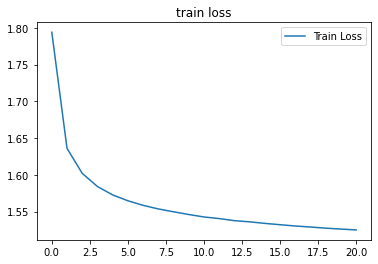

In [25]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

In [26]:
torch.cuda.is_available()

True